In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [23]:
rolling_window = 10
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [02:35<00:00, 72.58it/s]


In [26]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [116]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["sma_corr","sma"],num_of_groups=[3])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day"  and portfolio.selection_type.label == "top" \
            and portfolio.position_type.label == "long" and portfolio.allocation_type.label == "equal":
            portfolio.stoploss = 0.05
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

12

In [117]:
analysises = []
portfolio_value = 10
for min_price in tqdm([1]):
    for max_price in tqdm([3]):
        filtered_simulation = simulation[(simulation["adjclose"]<=max_price) & (simulation["adjclose"]>=min_price)].copy()
        if filtered_simulation.index.size > 0:
            for portfolio in filtered_portfolios:
                if max_price * portfolio.num_of_groups <= 10:
                    try:
                        trades = portfolio.trades(filtered_simulation.copy())
                        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
                        metrics = KPI.performance(trades,performance)
                        results = {**portfolio.to_dict(),**metrics.copy()}
                        results["portfolio"] = portfolio
                        results["rolling_window"] = rolling_window
                        results["max_price"] = max_price
                        results["min_price"] = min_price
                        analysises.append(results)
                    except Exception as e:
                        print(str(e))
                        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.71s/it]


In [118]:
a = pd.DataFrame(analysises)

In [119]:
metric = "raw_pnl"
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,num_of_groups,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,max_price,min_price
2,sma_corr,long,ROLLING_DOLLAR_VOLUME,top,0.05,3,1.936689e+08,8.950598e+10,0.95,5.923788,3.269343e+07,1.068335,0.965809,0.497161,1.016781,5.923788,<financial_common.portfolio_management.portfol...,10,3,1
8,sma,long,ROLLING_DOLLAR_VOLUME,top,0.05,3,1.189546e+08,4.782426e+10,0.95,5.898217,2.016789e+07,1.067953,0.965851,0.494458,1.016336,5.898217,<financial_common.portfolio_management.portfol...,10,3,1
3,sma_corr,long,SIMPLE_MOVING_AVERAGE,top,0.05,3,2.341900e+06,4.795419e+08,0.95,5.572514,4.202592e+05,1.061946,0.965098,0.493647,1.012907,5.572507,<financial_common.portfolio_management.portfol...,10,3,1
9,sma,long,SIMPLE_MOVING_AVERAGE,top,0.05,3,1.491962e+06,3.232402e+08,0.95,5.352604,2.787357e+05,1.061855,0.965142,0.490132,1.012545,5.352594,<financial_common.portfolio_management.portfol...,10,3,1
7,sma,long,AVERAGE_RETURN,top,0.05,3,3.800440e+05,5.515974e+07,0.95,4.554024,8.345233e+04,1.058833,0.965707,0.489862,1.011326,4.553990,<financial_common.portfolio_management.portfol...,10,3,1
1,sma_corr,long,AVERAGE_RETURN,top,0.05,3,2.678260e+05,3.973014e+07,0.95,4.455539,6.011080e+04,1.058667,0.965662,0.487699,1.011020,4.455492,<financial_common.portfolio_management.portfol...,10,3,1
5,sma_corr,long,DISTANCE,top,0.05,3,6.937918e+04,8.081823e+06,0.95,3.630781,1.910861e+04,1.055670,0.966958,0.483915,1.009887,3.630630,<financial_common.portfolio_management.portfol...,10,3,1
11,sma,long,DISTANCE,top,0.05,3,7.319989e+04,7.972138e+06,0.95,3.865760,1.893545e+04,1.055620,0.967014,0.484455,1.009939,3.865608,<financial_common.portfolio_management.portfol...,10,3,1
6,sma,long,STANDARD_DEV,top,0.05,3,2.170071e+04,1.854872e+06,0.95,3.790844,5.724506e+03,1.049703,0.967659,0.501757,1.008825,3.790342,<financial_common.portfolio_management.portfol...,10,3,1
0,sma_corr,long,STANDARD_DEV,top,0.05,3,1.423589e+04,1.394702e+06,0.95,3.676630,3.871996e+03,1.049151,0.967602,0.500946,1.008454,3.675887,<financial_common.portfolio_management.portfol...,10,3,1


In [120]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [121]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

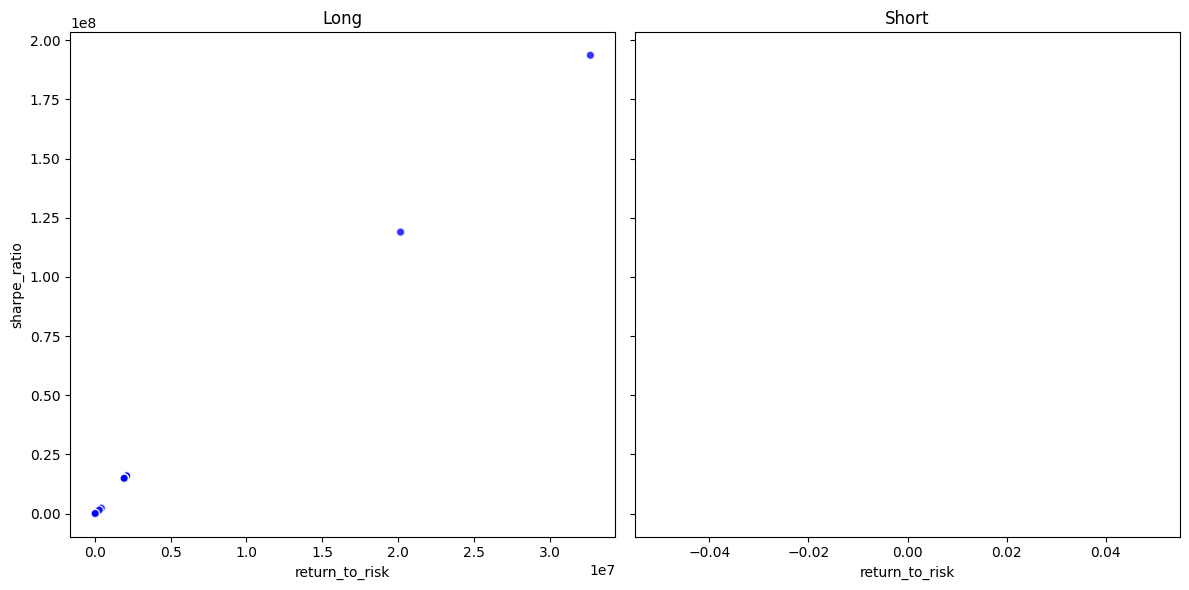

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [129]:
pm = top["portfolio"]
filtered_simulation = simulation[(simulation["adjclose"]<=top["max_price"]) & (simulation["adjclose"]>=top["min_price"])]
trades = pm.trades(filtered_simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

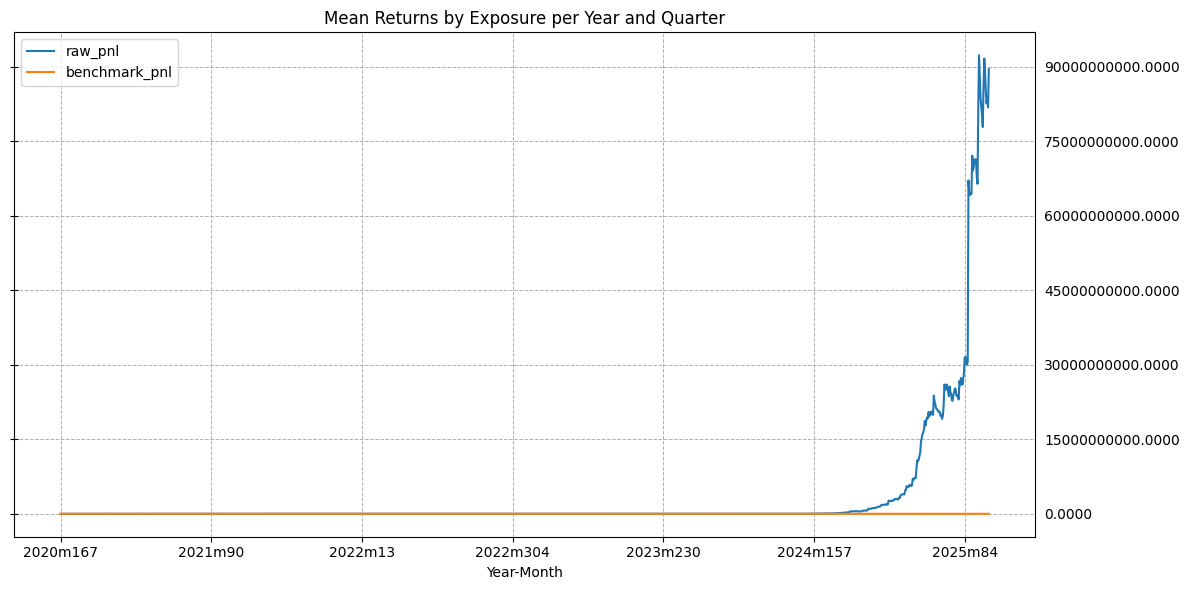

In [130]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [126]:
trades[["group_percentile","return"]].groupby("group_percentile").mean().sort_values("return",ascending=False)

,return
group_percentile,
2,1.019290
3,1.016275
1,1.014779


In [127]:
portfolio.sort_values("date")

,index,year,day,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,week,Year-Month
0,0,2020,167,2020-06-15 00:00:00+00:00,0.998328,0.998328,9.983276e-01,9.983276e-01,88.07,1.000000,6,2,25,2020m6
1,1,2020,168,2020-06-16 00:00:00+00:00,0.981783,0.981783,9.801410e-01,9.801410e-01,88.78,1.008062,6,2,25,2020m6
2,2,2020,169,2020-06-17 00:00:00+00:00,1.120262,1.120262,1.098014e+00,1.098014e+00,86.53,0.982514,6,2,25,2020m6
3,3,2020,170,2020-06-18 00:00:00+00:00,0.961519,0.961519,1.055762e+00,1.055762e+00,86.06,0.977177,6,2,25,2020m6
4,4,2020,171,2020-06-19 00:00:00+00:00,0.974078,0.974078,1.028395e+00,1.028395e+00,85.08,0.966050,6,2,25,2020m6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,1228,2025,125,2025-05-05 00:00:00+00:00,0.959722,0.959722,1.843970e+08,8.522088e+10,252.56,2.867719,5,2,19,2025m5
1229,1229,2025,126,2025-05-06 00:00:00+00:00,0.969149,0.969149,1.787082e+08,8.259172e+10,249.25,2.830135,5,2,19,2025m5
1230,1230,2025,127,2025-05-07 00:00:00+00:00,1.015459,1.015459,1.814708e+08,8.386850e+10,249.39,2.831725,5,2,19,2025m5
1231,1231,2025,128,2025-05-08 00:00:00+00:00,0.975325,0.975325,1.769930e+08,8.179901e+10,253.47,2.878052,5,2,19,2025m5


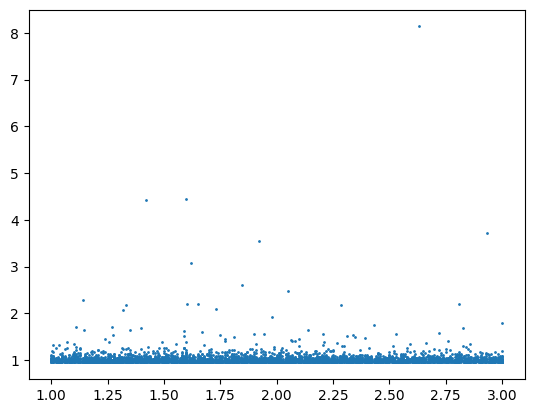

In [114]:
plt.scatter(trades["adjclose"],trades["weighted_return"],s=1)
plt.show()

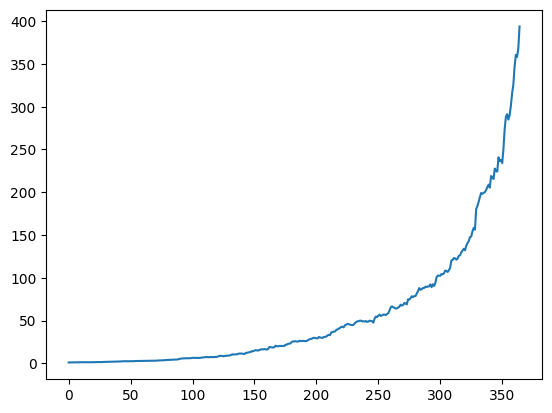

In [115]:
averaged_portfolio = portfolio.groupby("day").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()